In [56]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 1. Charger le dataset
dataset, info = tfds.load('malaria', as_supervised=True, with_info=True, shuffle_files=True)

In [57]:
# Informations sur le dataset
print("Description du dataset :")
print(info.description)
print("\nNombre total d'exemples :", info.splits['train'].num_examples)
print(info)

Description du dataset :
The Malaria dataset contains a total of 27,558 cell images with equal instances
of parasitized and uninfected cells from the thin blood smear slide images of
segmented cells.

Nombre total d'exemples : 27558
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Utilisateur\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
      

In [59]:
# 2. Définir les fractions pour division en entraînement, validation et test
# Récupérer les données d'entraînement
train_data = dataset['train']

# Mélanger les données avant de les diviser
train_data = train_data.shuffle(1000, seed=42)  # Mélanger avec une taille de tampon de 1000

# Diviser les données en sous-ensembles (80% train, 10% validation, 10% test)
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Calculer le nombre d'exemples pour chaque sous-ensemble
train_size = int(info.splits['train'].num_examples * train_split)
val_size = int(info.splits['train'].num_examples * val_split)
test_size = int(info.splits['train'].num_examples * test_split)

# Diviser les données en sous-ensembles
train_data = train_data.take(train_size)
val_data = dataset['train'].skip(train_size).take(val_size)
test_data = dataset['train'].skip(train_size + val_size).take(test_size)

# Vérification des tailles des datasets
print(f"Exemples d'entraînement : {len(list(train_data))}")
print(f"Exemples de validation : {len(list(val_data))}")
print(f"Exemples de test : {len(list(test_data))}")

Exemples d'entraînement : 22046
Exemples de validation : 2755
Exemples de test : 2755


In [60]:
# 3. Prétraitement des données
import tensorflow as tf

batch_size = 32
img_size = (128, 128)  # Taille des images cible

# Fonction de prétraitement des images (redimensionnement et normalisation)
def preprocess_image(image, label):
    """
    Prétraite une image :
    - Redimensionne l'image
    - Normalise les pixels entre 0 et 1
    """
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalisation entre 0 et 1
    return image, label

# Encodage binaire des labels : 1 pour 'Parasitized', 0 pour 'Uninfected'
def encode_label(label):
    """
    Cette fonction vérifie la valeur du label et l'encode.
    Ici, les labels sont déjà sous forme d'entiers (0 ou 1), donc on les laisse tels quels.
    """
    return tf.cast(label, tf.float32)  # Assurer que le label est bien au format float32

# Appliquer le prétraitement, l'augmentation et l'encodage binaire
def preprocess_and_encode(image, label):
    image, label = preprocess_image(image, label)
    label = encode_label(label)
    return image, label

# Optimisation du pipeline de données
AUTOTUNE = tf.data.AUTOTUNE

# Fonction pour préparer les données d'entraînement, validation et test
def prepare_data(dataset):
    """
    Prépare les données en appliquant les fonctions de prétraitement et d'encodage,
    puis les batchant et les préchargeant pour améliorer la vitesse d'entraînement.
    """
    dataset = dataset.map(preprocess_and_encode, num_parallel_calls=AUTOTUNE)  # Applique prétraitement et encodage
    dataset = dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)  # Batching et précharge des données
    return dataset

# Assurez-vous que les sous-ensembles train, validation, et test sont correctement récupérés

# Appliquer le prétraitement et l'augmentation des données d'entraînement
train_data = prepare_data(train_data)  # Le train_data est déjà un dataset préparé

# Prétraitement pour les jeux de validation et de test
val_data = prepare_data(val_data)  # Utilisez val_data récupéré précédemment
test_data = prepare_data(test_data)  # Utilisez test_data récupéré précédemment


Visualisation des données d'entraînement :


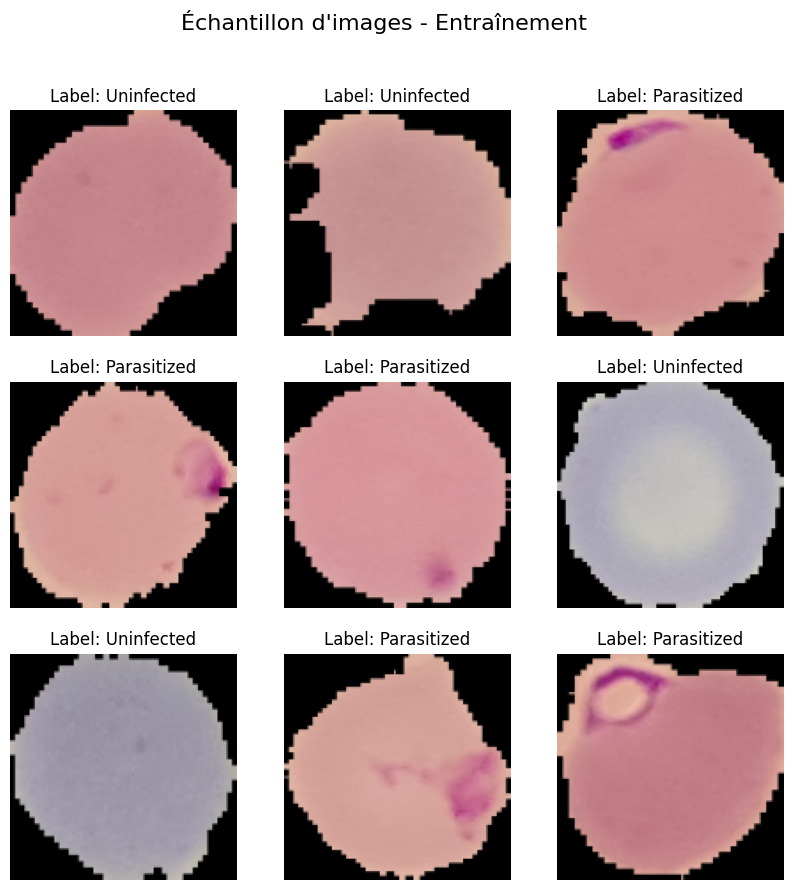


Visualisation des données de test :


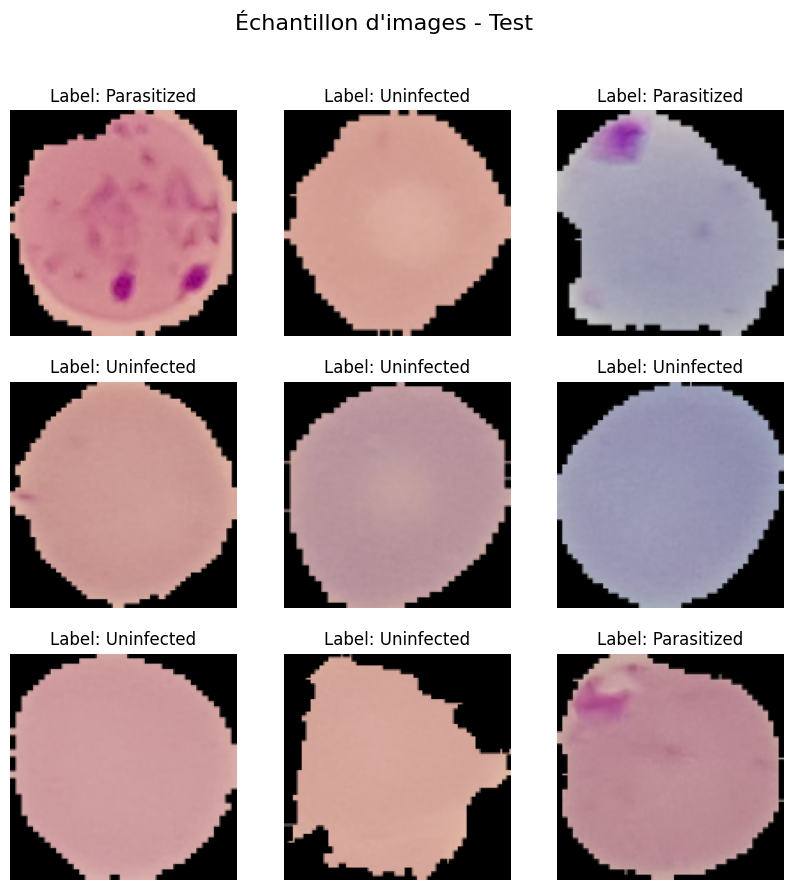


Visualisation des données de validation :


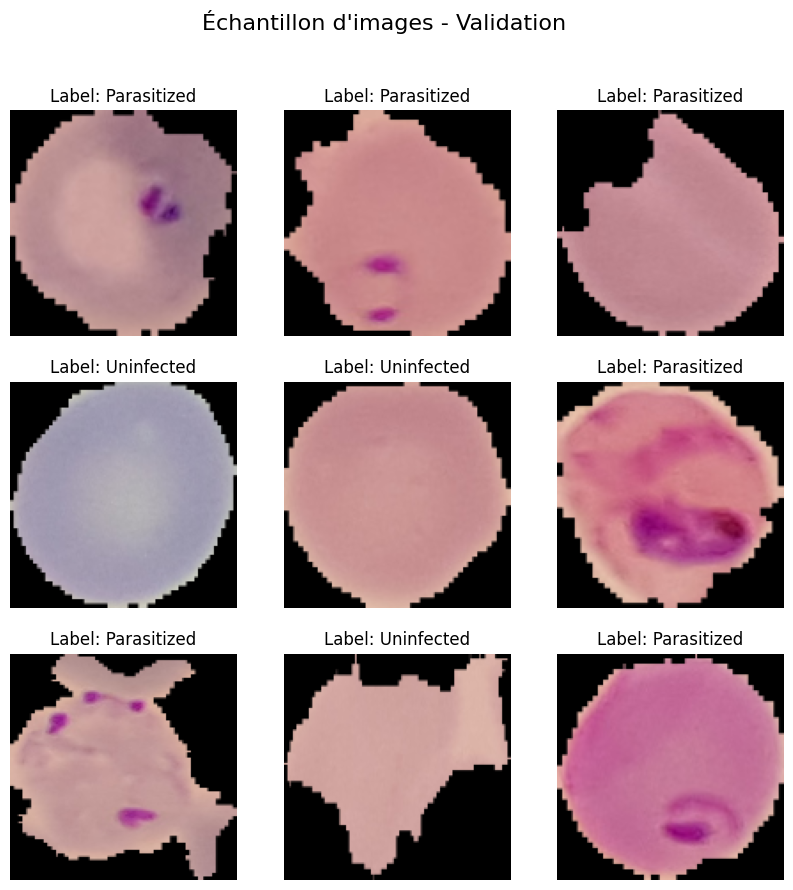

In [61]:
# 4. Visualiser un échantillon d'images et leurs labels
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_sample(dataset, title, class_names=['Parasitized', 'Uninfected']):
    plt.figure(figsize=(10, 10))

    # Prenez un seul batch pour la visualisation
    for images, labels in dataset.take(1):
        for i in range(9):  # Affichez les 9 premières images
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())  # Affichez la i-ème image du batch
            # Convertir le label binaire (0.0 ou 1.0) en texte
            label_index = int(labels[i].numpy())  # On prend la valeur 0 ou 1
            plt.title(f"Label: {class_names[label_index]}")  # Affichage du label en texte
            plt.axis("off")

    # Titre global pour l'affichage
    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualisation des échantillons pour chaque dataset
print("\nVisualisation des données d'entraînement :")
visualize_sample(train_data, "Échantillon d'images - Entraînement")

print("\nVisualisation des données de test :")
visualize_sample(test_data, "Échantillon d'images - Test")

print("\nVisualisation des données de validation :")
visualize_sample(val_data, "Échantillon d'images - Validation")




Répartition des classes - Entraînement :


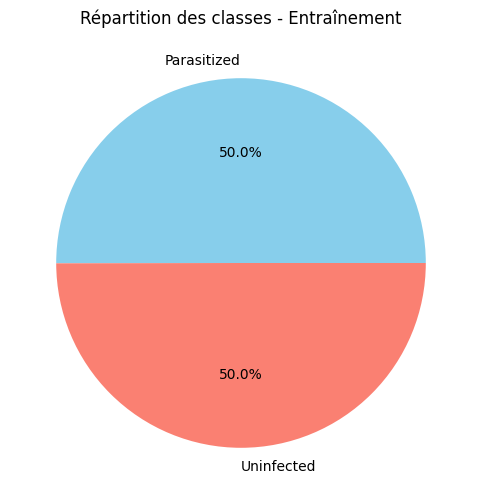


Répartition des classes - Test :


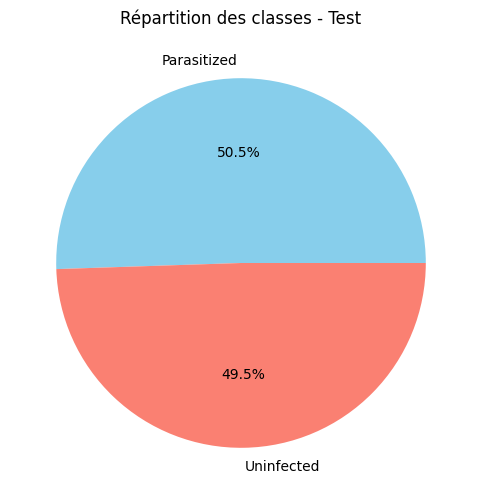


Répartition des classes - Validation :


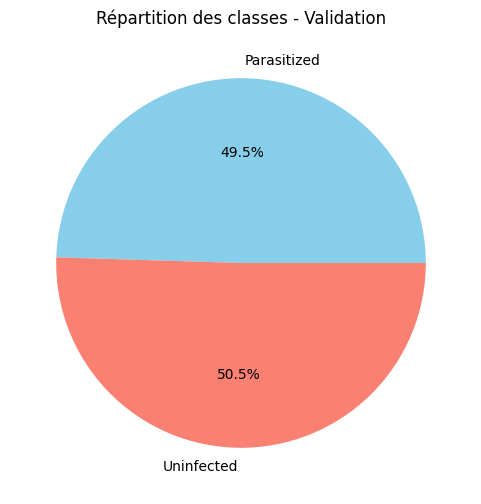

In [62]:
# répartion des classes
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_class_distribution(dataset, title, class_names=['Parasitized', 'Uninfected']):
    # Initialiser un tableau pour compter les occurrences des labels
    labels = []

    # Parcourir tout le dataset pour collecter les labels
    for _, label in dataset:
        labels.extend(label.numpy())  # Ajouter les labels du batch à la liste

    # Compter les occurrences des labels (0.0 et 1.0)
    unique, counts = np.unique(labels, return_counts=True)

    # Créer le graphique en camembert
    plt.figure(figsize=(6, 6))
    plt.pie(
        counts,
        labels=[class_names[int(i)] for i in unique],
        autopct='%1.1f%%',
        colors=['skyblue', 'salmon']
    )
    plt.title(title)
    plt.show()

# Visualisation de la répartition des classes pour chaque dataset
print("\nRépartition des classes - Entraînement :")
plot_class_distribution(train_data, "Répartition des classes - Entraînement")

print("\nRépartition des classes - Test :")
plot_class_distribution(test_data, "Répartition des classes - Test")

print("\nRépartition des classes - Validation :")
plot_class_distribution(val_data, "Répartition des classes - Validation")


In [84]:
from keras import Input
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# 1. Conception du modèle CNN
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Input

def create_model(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Bloc Convolutionnel 1
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)  # Dropout ajusté

    # Bloc Convolutionnel 2
    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)  # Dropout ajusté

    # Bloc Convolutionnel 3
    x = layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)  # Dropout ajusté

    # Couches entièrement connectées
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.5)(x)  # Régularisation Dropout ajustée
    outputs = layers.Dense(1, activation='sigmoid')(x)  # Sortie binaire

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Initialiser le modèle
model = create_model()

# Afficher un résumé du modèle
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [85]:
# 2. Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [86]:
# 3. Configuration des Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, LearningRateScheduler

# Define the callbacks
callbacks = [
    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',  # Monitor the validation loss
        patience=3,  # Stop after 3 epochs without improvement
        verbose=1,
        restore_best_weights=True  # Restore weights from the best epoch
    ),

    # Reduce the learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',  # Monitor the validation loss
        factor=0.2,  # Reduce the learning rate by 80%
        patience=3,  # Wait for 3 epochs without improvement
        verbose=1
    ),

    # Save the best model weights based on validation loss
    ModelCheckpoint(
        'best_model.keras',  # File where the model will be saved
        monitor='val_loss',  # Monitor validation loss
        save_best_only=True,  # Save only the best model
        verbose=1
    )
]

In [87]:
# 4. Entraînement du modèle
epochs = 10
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.5825 - loss: 3.2811
Epoch 1: val_loss improved from inf to 1.53152, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 384s 553ms/step - accuracy: 0.5826 - loss: 3.2793 - val_accuracy: 0.6334 - val_loss: 1.5315 - learning_rate: 0.0010
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.7740 - loss: 1.1949
Epoch 2: val_loss improved from 1.53152 to 1.12088, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 404s 586ms/step - accuracy: 0.7741 - loss: 1.1950 - val_accuracy: 0.9383 - val_loss: 1.1209 - learning_rate: 0.0010
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.8716 - loss: 1.1017
Epoch 3: val_loss improved from 1.12088 to 0.81838, saving model to best_model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 391s 566ms/step - accuracy: 0.8716 - loss: 1.1016 - val_accuracy: 0.8893 - val_loss: 0.8184 - learning_rate: 0.0010
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/s

In [88]:
# 5. Évaluation des performances
print("\nÉvaluation sur les données de test :")
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Évaluation sur les données de test :
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.8923 - loss: 0.5332
Test Loss: 0.5299
Test Accuracy: 0.8915


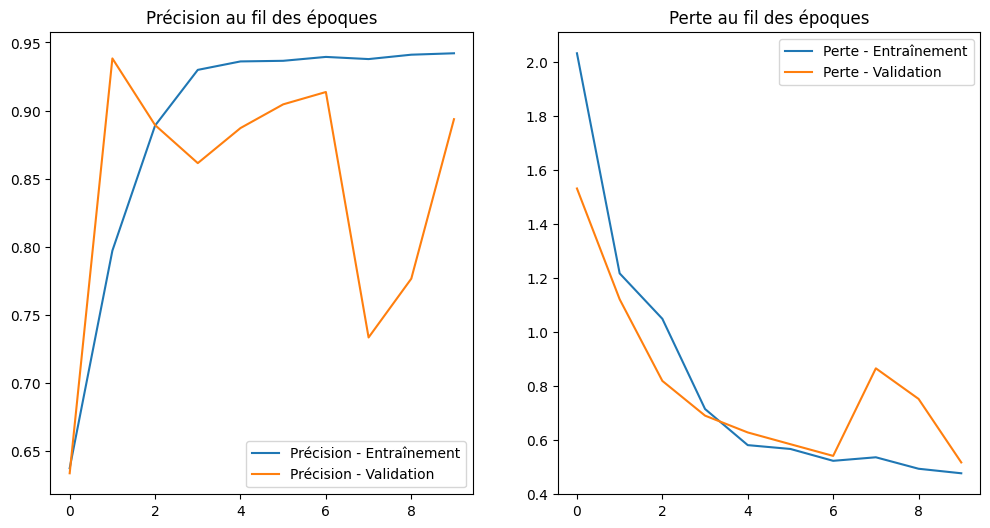

In [89]:
# 6. Affichage des courbes d'entraînement
def plot_training_history(history):
    """
    Affiche les courbes de précision et de perte au fil des époques.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Courbe de précision
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Précision - Entraînement')
    plt.plot(epochs_range, val_acc, label='Précision - Validation')
    plt.legend(loc='lower right')
    plt.title('Précision au fil des époques')

    # Courbe de perte
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Perte - Entraînement')
    plt.plot(epochs_range, val_loss, label='Perte - Validation')
    plt.legend(loc='upper right')
    plt.title('Perte au fil des époques')

    plt.show()

# Affichage des courbes
plot_training_history(history)


In [90]:
# Sauvegarde du modèle
model.save('model/model_cnn.keras')

In [91]:
# Chargement du best_model
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

# Évaluation des performances
print("\nÉvaluation sur les données de test :")
test_loss, test_accuracy = best_model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Évaluation sur les données de test :
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.8903 - loss: 0.5345
Test Loss: 0.5301
Test Accuracy: 0.8911
